# Final Project - Training Data

This Notebook loads and displays some examples from the training dataset.

The training dataset contains a total of 8443 samples. All groups have been given the same training dataset and the final report will be graded based on the performance on this training data.

* You should expect the test dataset to have the same format as the training data: $270,000\times M$ ```numpy``` array, where $M$ is the number of test samples.
* This means that *any* pre-processing applied in the training data should also be applied in the test data.

---

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from utils import RotNetDataGenerator, crop_largest_rectangle, angle_error, rotate, binarize_images, display_examples
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
from skimage.transform import resize
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer

In [4]:
train_df=pd.read_csv('sign_mnist_train.csv')
test_df=pd.read_csv('sign_mnist_test.csv')

In [5]:
train_label=train_df['label']
train_label.head()
trainset=train_df.drop(['label'],axis=1)

In [6]:
X_train = trainset.values
X_train = trainset.values.reshape(-1,28,28,1)
print(X_train.shape)

(1726, 28, 28, 1)


In [11]:
X_train[0].shape

(28, 28, 1)

In [5]:
test_label=test_df['label']
X_test=test_df.drop(['label'],axis=1)
print(X_test.shape)

(7172, 784)


In [6]:
lb=LabelBinarizer()
y_train=lb.fit_transform(train_label)
y_test=lb.transform(test_label)

In [7]:
X_test=X_test.values.reshape(-1,28,28,1)

In [8]:
X_train = np.squeeze(X_train, axis=-1)
X_test = np.squeeze(X_test, axis=-1)

In [9]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(27455, 28, 28) (27455, 24) (7172, 28, 28) (7172, 24)


In [10]:
# number of convolutional filters to use
nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

nb_train_samples, img_rows, img_cols = X_train.shape
img_channels = 1
input_shape = (img_rows, img_cols, img_channels)
nb_test_samples = X_test.shape[0]
nb_classes = 360

# model definition
input = Input(shape=(img_rows, img_cols, img_channels))
x = Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                  activation='relu')(input)
x = Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                  activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(nb_classes, activation='softmax')(x)

model = Model(inputs=input, outputs=x)

2023-11-20 17:38:01.801722: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 17:38:03.073326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-11-20 17:38:03.076698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0


In [11]:
# model compilation
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[angle_error, 'accuracy'])

In [12]:
# training parameters
batch_size = 128
nb_epoch = 50
output_filename = "rotnet"

# callbacks
checkpointer = ModelCheckpoint(
    filepath=output_filename,
    save_best_only=True
)
early_stopping = EarlyStopping(patience=2)
tensorboard = TensorBoard()

# training loop
history = model.fit(
    RotNetDataGenerator(X_train, preprocess_func=binarize_images),
    steps_per_epoch=nb_train_samples // batch_size,  # Adjust this based on your dataset size
    epochs=nb_epoch,
    validation_data=RotNetDataGenerator(X_test, preprocess_func=binarize_images),
    validation_steps=nb_test_samples // batch_size,  # Adjust this based on your dataset size
    verbose=1,
    callbacks=[checkpointer, early_stopping, tensorboard]
)

Epoch 1/50


2023-11-20 17:38:04.953674: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-11-20 17:38:06.553007: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


209/214 [============================>.] - ETA: 0s - loss: 1.1071 - angle_error: 38.6576 - accuracy: 0.6476

2023-11-20 17:38:10.161202: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: rotnet/assets
214/214 [==============================] - 7s 16ms/step - loss: 1.0831 - angle_error: 37.7938 - accuracy: 0.6554 - val_loss: 0.0276 - val_angle_error: 0.5022 - val_accuracy: 0.9944
Epoch 2/50
214/214 [==============================] - 3s 14ms/step - loss: 0.0491 - angle_error: 0.9923 - accuracy: 0.9890 - val_loss: 0.0089 - val_angle_error: 0.1758 - val_accuracy: 0.9980
Epoch 3/50
214/214 [==============================] - 3s 12ms/step - loss: 0.0296 - angle_error: 0.6374 - accuracy: 0.9929 - val_loss: 0.0121 - val_angle_error: 0.2511 - val_accuracy: 0.9972
Epoch 4/50
214/214 [==============================] - 3s 12ms/step - loss: 0.0237 - angle_error: 0.4928 - accuracy: 0.9945 - val_loss: 0.0094 - val_angle_error: 0.1507 - val_accuracy: 0.9983


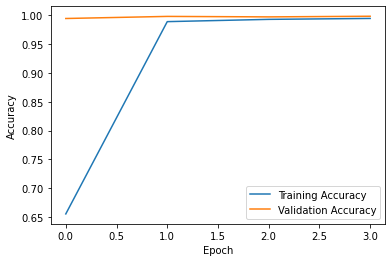

In [13]:
# Access accuracy from history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot accuracy over epochs
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
print(training_accuracy[-1])
print(validation_accuracy[-1])

0.9945239424705505
0.9983258843421936


In [15]:
# randomly rotate an image
original_img = X_test[0]
rotation_angles = [0, 90, 180, 270]
true_angle = np.random.choice(rotation_angles)
rotated_img = rotate(original_img, true_angle)
print('True angle: ', true_angle)

# add dimensions to account for the batch size and channels, 
rotated_img = rotated_img[np.newaxis, :, :, np.newaxis]
# convert to float
rotated_img = rotated_img.astype('float32')
# binarize image
rotated_img_bin = binarize_images(rotated_img)

resized_rotated_img = resize(rotated_img_bin[0, :, :, 0], (28, 28))[np.newaxis, :, :, np.newaxis]

# predict rotation angle
output = model.predict(resized_rotated_img)
predicted_angle = np.argmax(output)
print('Predicted angle: ', predicted_angle)

True angle:  90
Predicted angle:  90


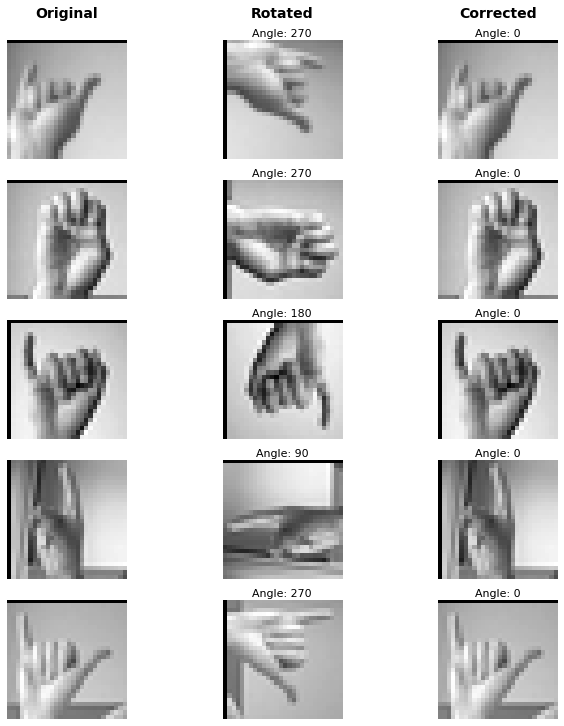

In [16]:
num_images = 5

display_examples(
    model, 
    X_test,
    num_images=num_images,
    preprocess_func=binarize_images,
)